# 使用机器学习模型进行交易
本教程将展示如何使用backtesting.py框架训练和回溯测试机器学习价格预测模型。假设您已经熟悉基本的框架用法和一般的机器学习。

在本教程中，我们将使用近一年的每小时欧元/美元外汇数据样本：

In [7]:
from backtesting.test import EURUSD, GOOG, SMA

data = EURUSD.copy()
data[400:]

,Open,High,Low,Close,Volume
2017-05-12 01:00:00,1.08654,1.08711,1.08646,1.08704,222
2017-05-12 02:00:00,1.08702,1.08738,1.08699,1.08718,184
2017-05-12 03:00:00,1.08714,1.08724,1.08696,1.08696,137
2017-05-12 04:00:00,1.08694,1.08715,1.08668,1.08711,166
2017-05-12 05:00:00,1.08713,1.08726,1.08692,1.08714,188
...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065


在监督式机器学习中，我们尝试学习一个将输入特征向量（自变量）映射到已知输出值（因变量）的函数：

$$ f\colon X \to \mathbf{y} $$

这样，只要我们的模型函数足够，我们就可以从新获取的输入特征向量中预测未来的输出值，从而达到一定程度的确定性。在我们的示例中，我们将尝试在未来两天内将几个价格派生的特征和常见的技术指标映射到价格点。我们构建模型设计矩阵$X$下面:

In [8]:
def BBANDS(data, n_lookback, n_std):
    """波林格 区间 指标"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# 设计矩阵/独立特性: Design matrix / independent features:

# 价格衍生特性 Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# 指标特性
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# 一些日期时间特性
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

由于我们所有的指标都只使用过去的值，我们可以安全地提前预先计算设计矩阵。或者，我们每次在训练模型之前都会重建矩阵。

请注意虚构的情绪特征。在现实生活中，人们可以通过解析新闻来源，Twitter情绪，Stocktwits或类似内容来获得类似的功能。这只是为了显示输入数据可以包含各种附加解释列。


如前所述，我们的因变量将是未来两天的价格（回报），简化为值 1 当回报率为正（且显著）时，
−1 阴性时，或 0 当两天后的回报大约为零时。让我们编写一些返回模型矩阵的函数 X 和依赖类变量 y 作为普通的NumPy数组：

In [20]:
import numpy as np


def get_X(data):
    """返回模型设计矩阵 X"""
    X = data.filter(like='X').values
    # print(X.shape, X.ndim)
    return X


def get_y(data):
    """返回因变量 y"""
    y = data.Close.pct_change(48).shift(-48)  # 大约两天后返回
    y[y.between(-.004, .004)] = 0             # 货币贬值的回报率低于0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    # print(y.shape, y.ndim)
    return y


def get_clean_Xy(df):
    """返回(X, y)已清除的NaN值"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

让我们看看我们的数据如何使用来自最先进的scikit-learn Python机器学习包的简单k-最近邻（kNN）算法进行建模。
Let's see how our data performs modeled using a simple
[k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
(kNN) algorithm from the state of the art
[scikit-learn](https://scikit-learn.org)
Python machine learning package.
To avoid (or at least demonstrate)
[overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html),
为了避免（或至少演示）过拟合，总是将数据拆分为训练集和测试集;特别是，不要在构建模型的相同数据上验证模型性能。

Classification accuracy:  0.4210960032962505


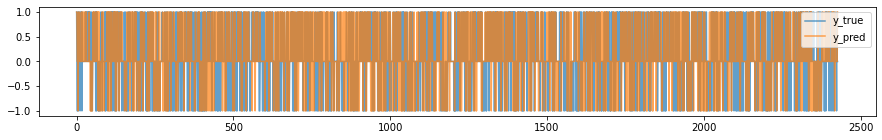

In [10]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))


我们看到预测到处都是（分类准确率为42%），但是在真正的回溯测试下，模型是否有任何用途？

让我们回溯测试一个简单的策略，每当预测为正时，以20：1的杠杆率以20：1的杠杆率购买资产（两天内的价格预计将上涨），并在预测为负时以相同的条款卖出，同时设置合理的止损和止盈水平。另请注意data.df访问器的稳定使用：

In [19]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def __init__(self, broker, data, params):
        super().__init__(broker, data, params)
        self.forecasts = None
        self.clf = None

    def init(self):        
        # 初始化我们的模型，一个kNN分类器
        self.clf = KNeighborsClassifier(7)

        # 在第一个N_TRAIN示例上提前训练分类器
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y 检验
        self.I(get_y, self.data.df, name='y_true')

        # 预备好 empty, all-NaN 预报指标
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # 跳过训练、样本内数据
        if len(self.data) < N_TRAIN:
            return

        # 只处理样本外的数据。准备一些变量
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # self.data.df.filter()
        # 预测下一个动作
        X = get_X(self.data.df.iloc[-1:])
        predit = self.clf.predict(X)
        forecast = predit[0]

        # 更新标绘的“预测”指标
        self.forecasts[-1] = forecast

        # 如果我们的预测是向上的，而我们并没有持有多头头寸，那么就买入10%的可用账户权益的多头订单。反之亦然。
        # 同时设定目标获利和止损价格为当前收盘价的一个delta值。
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.1, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.1, tp=lower, sl=upper)

        # 此外，对已经开仓超过两天的交易设置积极的止损
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

Wall time: 13.1 s


Start                     2017-04-25 12:00:00
End                       2018-02-07 15:00:00
Duration                    288 days 03:00:00
Exposure Time [%]                   79.412365
Equity Final [$]                 11928.661716
Equity Peak [$]                  12265.240823
Return [%]                          19.286617
Buy & Hold Return [%]               12.869869
Return (Ann.) [%]                   19.800826
Volatility (Ann.) [%]               11.348193
Sharpe Ratio                         1.744844
Sortino Ratio                        3.257889
Calmar Ratio                         3.970922
Max. Drawdown [%]                   -4.986455
Avg. Drawdown [%]                   -0.565214
Max. Drawdown Duration       42 days 00:00:00
Avg. Drawdown Duration        2 days 16:00:00
# Trades                                  354
Win Rate [%]                        52.542373
Best Trade [%]                       0.578258
Worst Trade [%]                     -0.519427
Avg. Trade [%]                    

In [16]:
bt.plot()

Row(id='3407', ...)

尽管我们的胜率很糟糕，但该策略似乎有利可图。让我们看看它在前行优化下的表现，类似于k-fold或leave-one-out交叉验证：

In [13]:
%%time

class MLWalkForwardStrategy(MLTrainOnceStrategy):
    def next(self):
        # 如果可用值太少，则跳过冷启动阶段
        if len(self.data) < N_TRAIN:
            return

        # 每20次迭代重新训练模型。
        # 由于20 << N_TRAIN，我们在“最近的训练例子”方面没有损失太多，但速度是显著的!
        if len(self.data) % 20:
            return super().next()

        # 对最后一个N_TRAIN值进行再训练
        df = self.data.df[-N_TRAIN:]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # 现在，模型已经拟合，继续与MLTrainOnceStrategy相同的操作
        super().next()


bt = Backtest(data, MLWalkForwardStrategy, commission=.0002, margin=.05)
bt.run()

Wall time: 8.5 s


Start                     2017-04-25 12:00:00
End                       2018-02-07 15:00:00
Duration                    288 days 03:00:00
Exposure Time [%]                   71.720057
Equity Final [$]                  7652.547522
Equity Peak [$]                  10026.049222
Return [%]                         -23.474525
Buy & Hold Return [%]               12.869869
Return (Ann.) [%]                  -23.972268
Volatility (Ann.) [%]                7.097444
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.693104
Avg. Drawdown [%]                  -23.693104
Max. Drawdown Duration      265 days 00:00:00
Avg. Drawdown Duration      265 days 00:00:00
# Trades                                  324
Win Rate [%]                        41.666667
Best Trade [%]                       0.384255
Worst Trade [%]                     -0.506643
Avg. Trade [%]                    

In [14]:
bt.plot()

Row(id='2475', ...)

显然，当以滚动方式对过去的数据点进行反复重新训练时，我们的基本模型泛化很差，性能也不太好。N_TRAIN

这是一个简单而人为的、开玩笑的例子，展示了一种将机器学习预测模型与backtesting.py框架结合使用的方法。实际上，您将需要一个更好的功能空间，更好的模型（参见深度学习）和更好的资金管理策略，以便在自动化的短期外汇交易中实现一致的利润。更恰当的数据科学是敏锐的读者的练习。

我想到的一些即时优化技巧是：

数据为王。确保您的设计矩阵尽可能具有最佳的模型功能，并与您选择的目标变量相关联，而不仅仅是表示随机噪声。
而不是对单个目标变量y进行建模，对大量目标/类变量进行建模，可能比上面的"48小时回报"设计得更好。
对一切进行建模：预测价格、交易量、"起飞"前的时间、SL/TP 水平、最佳头寸规模...
在进入交易之前，通过增加所需的信念并施加额外的领域专业知识和自由裁量权 来限制减少误报。
此外，请务必熟悉完整的 Backtesting.py API参考
[Backtesting.py API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules)